In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

# Loading the raw data

In [3]:
raw_data = pd.read_csv('car_data.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


# Preprocessing

In [10]:
# Descriptive statistics are very useful for initial exploration of the variables
raw_data.describe()

,Price,Mileage,EngineV,Year
count,4173.000000,4345.000000,4195.000000,4345.000000
mean,19418.746935,161.237284,2.790734,2006.550058
std,25584.242620,105.705797,5.066437,6.719097
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,86.000000,1.800000,2003.000000
50%,11500.000000,155.000000,2.200000,2008.000000
75%,21700.000000,230.000000,3.000000,2012.000000
max,300000.000000,980.000000,99.990000,2016.000000


In [14]:
raw_data.describe(include='object')

,Brand,Body,Engine Type,Registration,Model
count,4345,4345,4345,4345,4345
unique,7,6,4,2,312
top,Volkswagen,sedan,Diesel,yes,E-Class
freq,936,1649,2019,3947,199


## Determining the variables of interest

In [16]:
data = raw_data.drop(['Model'], axis=1)

## Missing values

In [17]:
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [18]:
## data.fillna(data.loc[:, ['Price', 'EngineV']].mean(), inplace=True)
# Let's simply drop all missing values
# This is not always recommended, however, when we remove less than 5% of the data, it is okay
data.dropna(axis=0, inplace=True)
data.isnull().sum()

Brand           0
Price           0
Body            0
Mileage         0
EngineV         0
Engine Type     0
Registration    0
Year            0
dtype: int64

## Outliers

In [20]:
# Outliers are a great issue for OLS, thus we must deal with them in some way
# We can deal with the problem easily by removing 0.5%, or 1% of the problematic samples

price_quantile = data.Price.quantile(0.99)
data = data.loc[data.Price < price_quantile]

mileage_quantile = data.Mileage.quantile(0.99)
data = data.loc[data.Mileage < mileage_quantile]

engineV_quantile = data.EngineV.quantile(0.99)
data = data.loc[data.EngineV < 6.5] # An area expert could help determine the outliers

year_quantile = data.Year.quantile(0.01)
data = data.loc[data.Year > year_quantile]

data.reset_index(drop=True, inplace=True)
data.describe()

,Price,Mileage,EngineV,Year
count,3731.000000,3731.000000,3731.000000,3731.000000
mean,17564.165133,158.183329,2.448389,2007.003484
std,16578.248444,90.502080,0.955568,5.615923
min,800.000000,0.000000,0.600000,1991.000000
25%,7500.000000,93.000000,1.800000,2003.000000
50%,11800.000000,156.000000,2.200000,2008.000000
75%,21500.000000,220.000000,3.000000,2012.000000
max,103999.000000,396.000000,6.300000,2016.000000


# Distribution Probability Function

<Axes: xlabel='Year', ylabel='Count'>

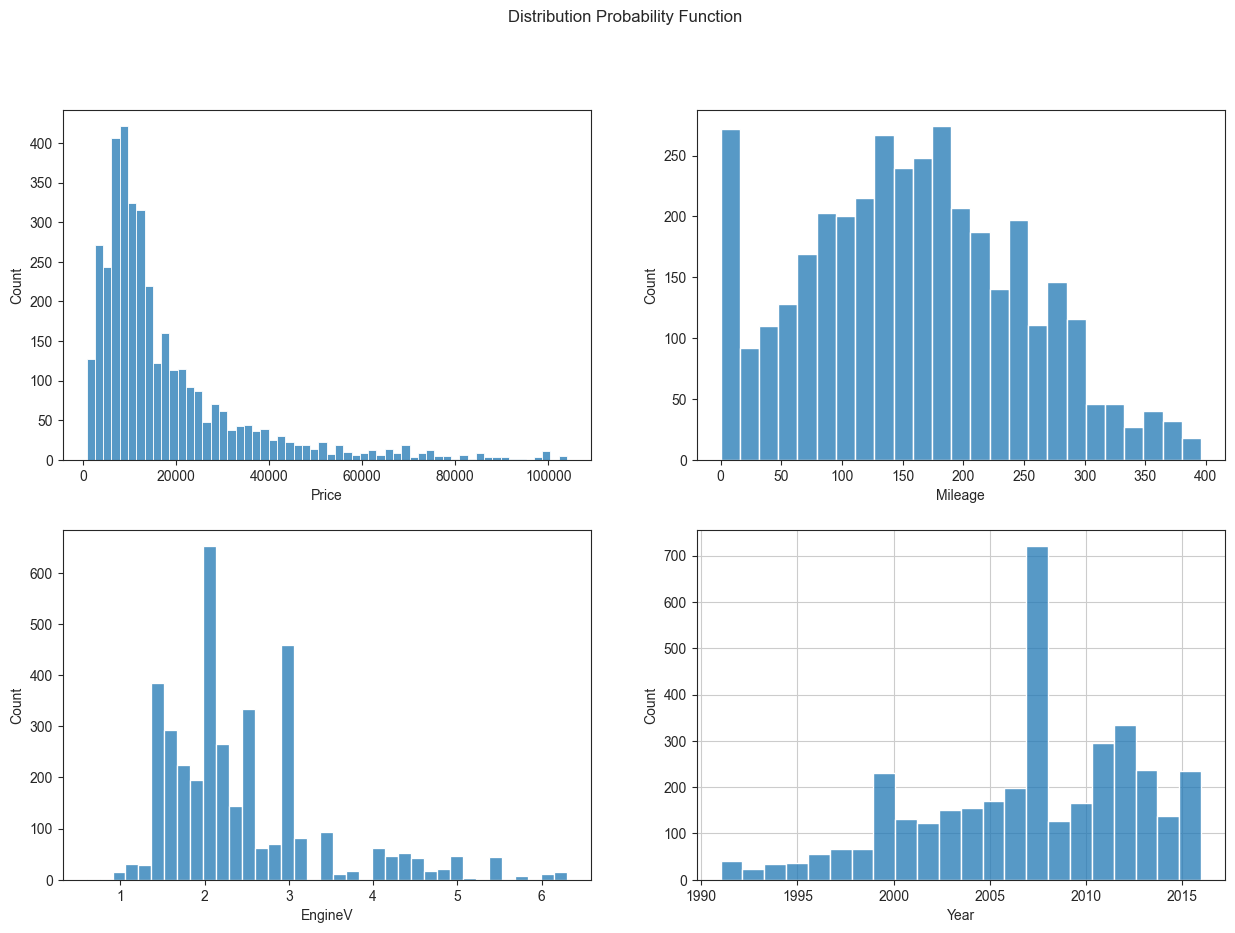

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution Probability Function')
sns.set_style('ticks')
plt.grid(True)

sns.histplot(data.Price, ax=axes[0][0])
sns.histplot(data.Mileage, ax=axes[0][1])
sns.histplot(data.EngineV, ax=axes[1][0])
sns.histplot(data.Year, ax=axes[1][1])

# Dummy Variables
  Is a binary variable that represents categorical data. The pandas function get_dummies maps categorical variables into dummies.

In [22]:
# It is extremely important that we drop one of the dummies, alternatively we will introduce multicollinearity
data = pd.get_dummies(data, drop_first=True) * 1
data

,Price,Mileage,EngineV,Year,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,4200.0,277,2.0,1991,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,13300.0,358,5.0,2003,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
2,23000.0,240,4.2,2007,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,18300.0,120,2.0,2011,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
4,14200.0,200,2.7,2006,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3726,6800.0,152,1.6,2007,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1
3727,11500.0,163,2.5,2008,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
3728,17900.0,35,1.6,2014,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1
3729,6500.0,1,3.5,1999,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1


# Assumptions
## Linearity

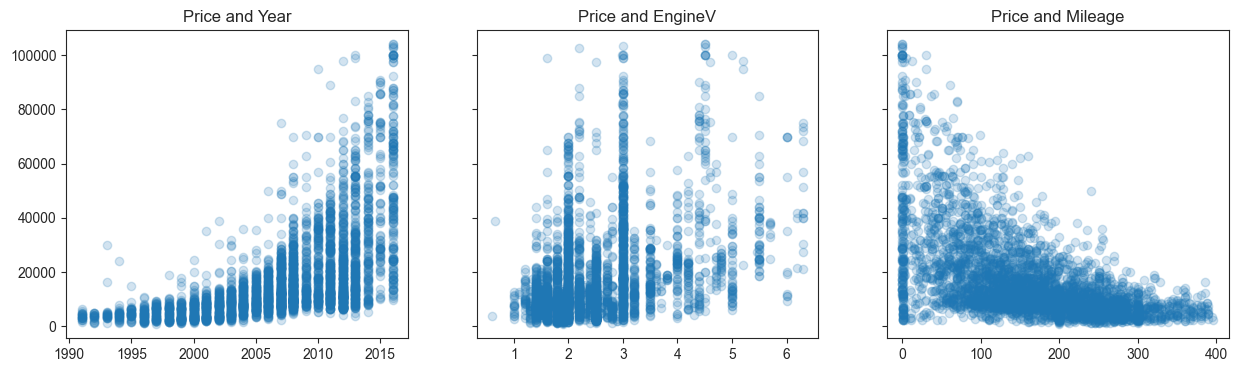

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(15, 4))

ax1.scatter(data.Year, data.Price, alpha=0.2)
ax1.set_title('Price and Year')

ax2.scatter(data.EngineV, data.Price, alpha=0.2)
ax2.set_title('Price and EngineV')

ax3.scatter(data.Mileage, data.Price, alpha=0.2)
ax3.set_title('Price and Mileage')

plt.show()

There is a exponential (non linear) relationship between the independent and dependent variables. By taking the log of one or both variables, the model can capture the percent change instead of unit change

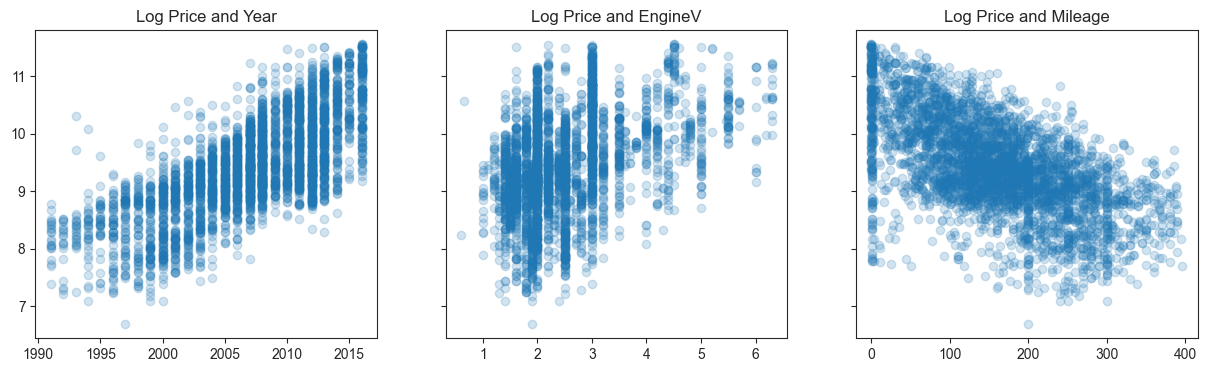

In [24]:
data['Log_Price'] = np.log(data.Price)
data.drop(['Price'], axis=1, inplace=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(15, 4))

ax1.scatter(data.Year, data.Log_Price, alpha=0.2)
ax1.set_title('Log Price and Year')

ax2.scatter(data.EngineV, data.Log_Price, alpha=0.2)
ax2.set_title('Log Price and EngineV')

ax3.scatter(data.Mileage, data.Log_Price, alpha=0.2)
ax3.set_title('Log Price and Mileage')

plt.show()

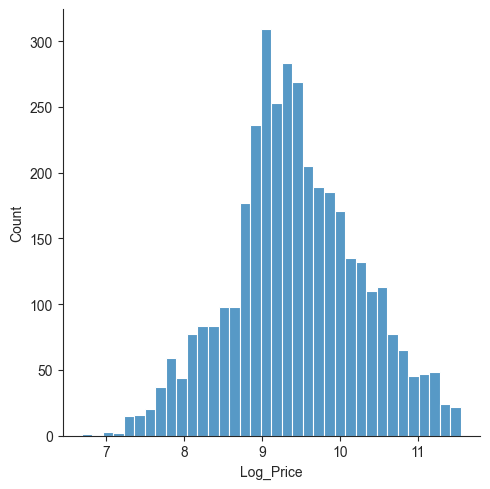

In [25]:
sns.displot(data.Log_Price)

## Multicollinearity
Occurs when two or more predictor variables are highly correlated to each other, such that they do not provide unique or independent information in the regression model. If the degree of correlation is high enough, it can cause problems when fitting and determining the exact effect of each variable on the target.

In [26]:
vif_variables = data

vif = pd.DataFrame(np.array(
    [[variance_inflation_factor(vif_variables.values, i) for i in range(vif_variables.shape[1])],
     np.array(vif_variables.columns)]
), index=['VIF', 'features']).T

vif

,VIF,features
0,9.431071,Mileage
1,13.963338,EngineV
2,586.161542,Year
3,2.608412,Brand_BMW
4,3.011181,Brand_Mercedes-Benz
5,2.105321,Brand_Mitsubishi
6,2.745048,Brand_Renault
7,2.557259,Brand_Toyota
8,3.564189,Brand_Volkswagen
9,1.820094,Body_hatch


Obviously, the dependent variable has a very high VIF. This implies that it is most definitely **linearly correlated** with all the other variables. However, to actually assess multicollinearity for the predictors, we have to drop the target.

In [27]:
vif_variables = data.drop(['Log_Price'], axis=1)

vif = pd.DataFrame(np.array(
    [[variance_inflation_factor(vif_variables.values, i) for i in range(vif_variables.shape[1])],
     np.array(vif_variables.columns)]
), index=['VIF', 'features']).T

vif

,VIF,features
0,5.173834,Mileage
1,11.969122,EngineV
2,44.707676,Year
3,2.606782,Brand_BMW
4,3.010437,Brand_Mercedes-Benz
5,1.969372,Brand_Mitsubishi
6,2.485532,Brand_Renault
7,2.527116,Brand_Toyota
8,3.489735,Brand_Volkswagen
9,1.688611,Body_hatch


In [28]:
data.drop(['Year'], axis=1, inplace=True)
vif_variables = data.drop(['Log_Price'], axis=1)

vif = pd.DataFrame(np.array(
    [[variance_inflation_factor(vif_variables.values, i) for i in range(vif_variables.shape[1])],
     np.array(vif_variables.columns)]
), index=['VIF', 'features']).T

vif

,VIF,features
0,4.748291,Mileage
1,7.903114,EngineV
2,2.279314,Brand_BMW
3,2.807147,Brand_Mercedes-Benz
4,1.651394,Brand_Mitsubishi
5,2.118126,Brand_Renault
6,2.19944,Brand_Toyota
7,2.863042,Brand_Volkswagen
8,1.470034,Body_hatch
9,1.53857,Body_other


# Linear Regression Model

In [29]:
targets = data.Log_Price
inputs = data.drop(['Log_Price'], axis=1)

## Scaling

In [30]:
scaler = StandardScaler()
inputs_scaled = scaler.fit_transform(inputs)

## Train test split

- **Underfitting** - Bias refers to error due to overly simplistic assumptions in the learning algorithm. These assumptions make the model easier to comprehend and learn but might not capture the underlying complexities of the data. **When a model has poor performance both on the training and testing data** means high bias because of the simple mode, indicating underfitting

- **Overfitting** - Variance, on the other hand, is the error due to the model's sensitivity to fluctuations in the training data. High variance occurs when a model learns the training data's noise and random fluctuations rather than the underlying pattern. As result, **the model performs well on the training data but poorly on the testing data**, indicating overfitting

In [31]:
# By default, 25% data is test set and 75% data goes into training set.
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365) ## 42

x_train = pd.DataFrame(x_train).reset_index(drop=True)
x_test = pd.DataFrame(x_test).reset_index(drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)

## Creating the Regression

In [32]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

## Testing

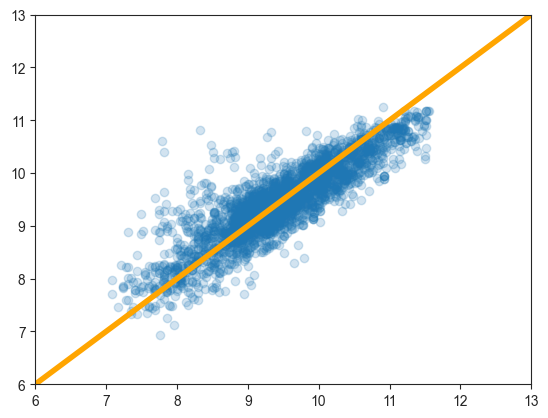

In [33]:
predicted_y = reg.predict(x_train)

# The simplest way to compare the targets (y_train) and the predictions (predicted_y) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction

plt.scatter(y_train, predicted_y, alpha=0.2)
plt.plot([0,15], [0,15], lw=4, c='orange')

plt.xlim(6,13)
plt.ylim(6,13)

plt.show()

## Residual Distribution

Text(0.5, 1.0, 'Residuals PDF')

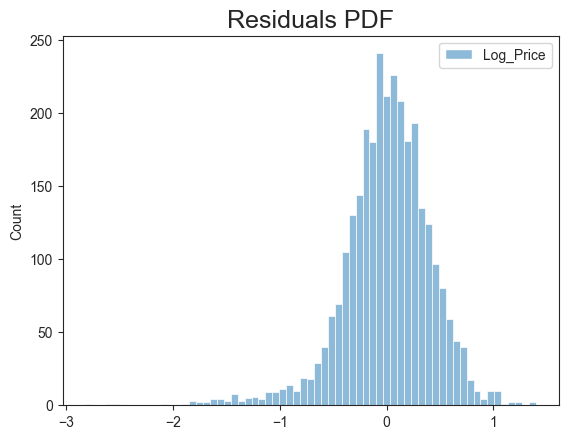

In [34]:
# In the best case scenario this plot should be normally distributed
sns.histplot(y_train - predicted_y)
plt.title('Residuals PDF', size=18)

## Adjusted R Squared
Measures the proportion of change in the dependent variable that is predictable from the independent variable, while adjusting for the numbers of predictors

$R^2_{adj} = 1 - (1-R^2)*\frac{n-1}{n-p-1}$

In [35]:
r2 = reg.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]

adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adj_r2

0.7522854302778078

## Feature Selection

In [36]:
p_values = f_regression(inputs, targets)[1]
feature_sel = pd.DataFrame(inputs.columns.values, columns=['Features'])
feature_sel['P Values'] = p_values

feature_sel

,Features,P Values
0,Mileage,0.000000e+00
1,EngineV,3.776293e-151
2,Brand_BMW,6.040478e-10
3,Brand_Mercedes-Benz,8.343814e-09
4,Brand_Mitsubishi,4.556865e-06
5,Brand_Renault,7.351426e-42
6,Brand_Toyota,1.349593e-22
7,Brand_Volkswagen,3.198439e-09
8,Body_hatch,1.590232e-16
9,Body_other,5.658330e-03


## Weights and Bias

In [37]:
features = np.append('Bias', inputs.columns.values)
weights = np.append(reg.intercept_, reg.coef_)

reg_summary = pd.DataFrame(features, columns=['Features'])
reg_summary['Weights'] = weights

reg_summary

,Features,Weights
0,Bias,9.426907
1,Mileage,-0.418274
2,EngineV,0.206958
3,Brand_BMW,0.008171
4,Brand_Mercedes-Benz,-0.021119
5,Brand_Mitsubishi,-0.147746
6,Brand_Renault,-0.194259
7,Brand_Toyota,-0.070407
8,Brand_Volkswagen,-0.104971
9,Body_hatch,-0.145079


# Testing

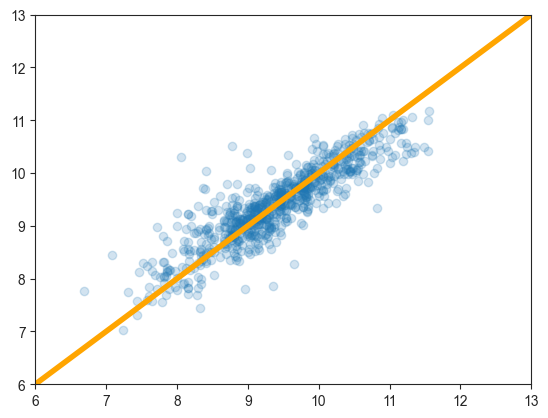

In [38]:
predicted_y_test = reg.predict(x_test)

plt.scatter(y_test, predicted_y_test, alpha=0.2)
plt.plot([0,15], [0,15], lw=4, c='orange')

plt.xlim(6,13)
plt.ylim(6,13)

plt.show()

In [39]:
reg_performance = pd.DataFrame(np.exp(predicted_y_test), columns=['Predicted'])
reg_performance['Target'] = np.exp(y_test)
reg_performance['Residual'] = reg_performance['Target'] - reg_performance['Predicted']
reg_performance['Difference%'] = np.absolute(reg_performance['Residual'] / reg_performance['Target'] * 100)
reg_performance

,Predicted,Target,Residual,Difference%
0,16516.113850,14300.0,-2216.113850,15.497300
1,9713.349307,6800.0,-2913.349307,42.843372
2,21675.686836,29500.0,7824.313164,26.523095
3,33608.428269,102800.0,69191.571731,67.306976
4,11414.365618,23300.0,11885.634382,51.011306
...,...,...,...,...
742,47497.925595,44000.0,-3497.925595,7.949831
743,12421.114322,28000.0,15578.885678,55.638877
744,10658.902577,12700.0,2041.097423,16.071633
745,19876.346636,22800.0,2923.653364,12.823041


In [40]:
reg_performance.describe()

,Predicted,Target,Residual,Difference%
count,747.000000,747.000000,747.000000,747.000000
mean,15633.486777,17149.857925,1516.371148,33.014198
std,11672.669300,16240.002102,8780.818013,51.894245
min,1125.854337,800.000000,-30286.986958,0.004966
25%,7674.129766,7000.000000,-2193.315126,10.795706
50%,12020.047786,11900.000000,-0.437072,21.728163
75%,19852.886755,20500.000000,2985.384142,35.862775
max,71599.741028,103999.000000,69191.571731,841.454812
